In [ ]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa #To deal with Audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf

from keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [ ]:
#colab- drive bağlantısını yap
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/YZ_Uygulamaları/Heartbeat_Sound"
print(os.listdir(data_path))

['extrastole', 'artifact', 'murmur', 'extrahls', 'normal', 'unlabel']


In [ ]:
tarin_data      = data_path 
unlabel_data    = data_path  + "/unlabel/"

normal_data     = tarin_data + '/normal/'
murmur_data     = tarin_data + '/murmur/'
extrastole_data = tarin_data + '/extrastole/'
artifact_data   = tarin_data + '/artifact/'
extrahls_data   = tarin_data + "/extrahls/"

In [ ]:
print("Normal files:", len(os.listdir(normal_data))) #length of normal training sounds
print("Murmur files:",len(os.listdir(murmur_data))) #length of murmur training sounds 
print("Extrastole files", len(os.listdir(extrastole_data))) #length of extrastole training sounds 
print("Artifact files:",len(os.listdir(artifact_data))) #length of artifact training sounds 
print("Extrahls files:",len(os.listdir(extrahls_data))) #length of extrahls training sounds 

print('TOTAL TRAIN SOUNDS:', len(os.listdir(normal_data)) 
                              + len(os.listdir(murmur_data))
                              + len(os.listdir(extrastole_data))
                              + len(os.listdir(artifact_data))
                              + len(os.listdir(extrahls_data)))

Normal files: 351
Murmur files: 129
Extrastole files 46
Artifact files: 40
Extrahls files: 19
TOTAL TRAIN SOUNDS: 585


In [ ]:
print("Test sounds: ", len(os.listdir(unlabel_data)))


Test sounds:  247


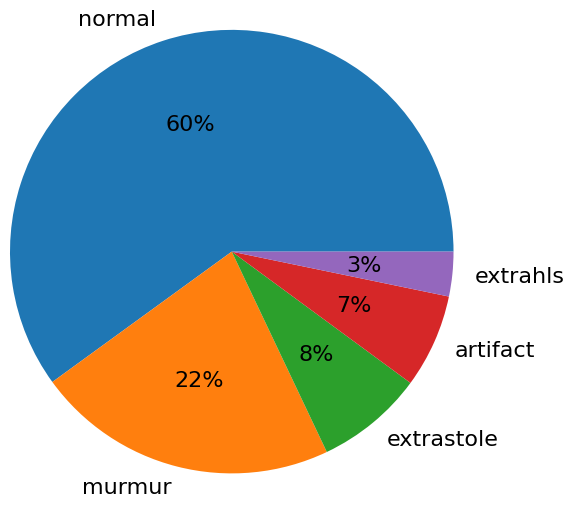

In [ ]:
x = np.array([len(os.listdir(normal_data)),
              len(os.listdir(murmur_data)),
              len(os.listdir(extrastole_data)),
              len(os.listdir(artifact_data)),
              len(os.listdir(extrahls_data))])
labels = ['normal', 'murmur', 'extrastole', 'artifact', 'extrahls']
plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, textprops={'fontsize': 16})
plt.show()

In [ ]:
# Listen to rondom audio from specific class
def random_sound (audio_class):
    random_sound = np.random.randint(0,len(os.listdir(audio_class))) 
    sound = os.listdir(audio_class)[random_sound]
    sound = audio_class+sound
    sound,sample_rate = librosa.load(sound)
    return ipd.Audio(sound,rate=sample_rate),sound

In [ ]:
# show waveform of audio from dataset 
# X axis, represents time.
# Y-axis measures displacement of air molecules.
# This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.  
def show_audio_waveform(audio_sample):
    plt.figure(figsize=(20,5))
    librosa.display.waveplot(audio_sample, sr = 22050)
#     plt.title("Sound")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [ ]:
# show spectrum of audio from dataset 
def show_audio_spectrum(audio_sample):
    sample_rate = 22050
    fft_normal = np.fft.fft(audio_sample)
    magnitude_normal = np.abs(fft_normal)
    freq_normal = np.linspace(0,sample_rate, len(magnitude_normal)) 
    half_freq = freq_normal[:int(len(freq_normal)/2)]
    half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]

    plt.figure(figsize=(12,8))
    plt.plot(half_freq,half_magnitude)
    plt.title("Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()

In [ ]:
# show specrogram of audio from dataset 
# the output is an image that represents a sound. 
# X-axis is for time, y-axis is for frequency and the color is for intensity
def show_spectrogram (audio_sample):    
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate

    print("STFT hop length duration is: {}s".format(hop_length_duration))
    print("STFT window duration is: {}s".format(n_fft_duration))

    # perform stft
    stft_normal = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft_normal)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    # display spectrogram
    plt.figure(figsize=(15,10))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    #plt.set_cmap("YlOrBr")
    plt.title("Spectrogram")

In [ ]:
# MFCCs
# extract 52 MFCCs
def show_mfcc_features(audio_sample):
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050
    
    MFCCs = librosa.feature.mfcc(audio_sample, n_fft=n_fft, hop_length=hop_length, n_mfcc=52)

    # display MFCCs
    plt.figure(figsize=(15,10))
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()

In [ ]:
normal_audio, normal_sample  = random_sound(normal_data)
normal_audio

In [ ]:
def show_audio_waveform(audio_sample):
    plt.figure(figsize=(20, 5))
    plt.plot(audio_sample)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

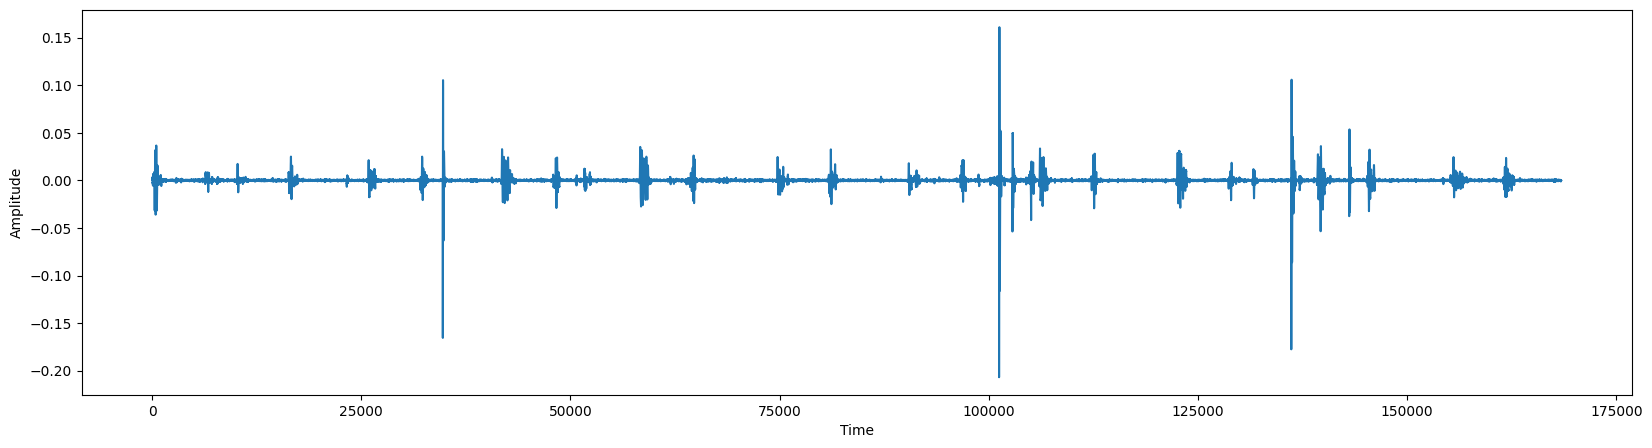

In [ ]:
show_audio_waveform(normal_sample)


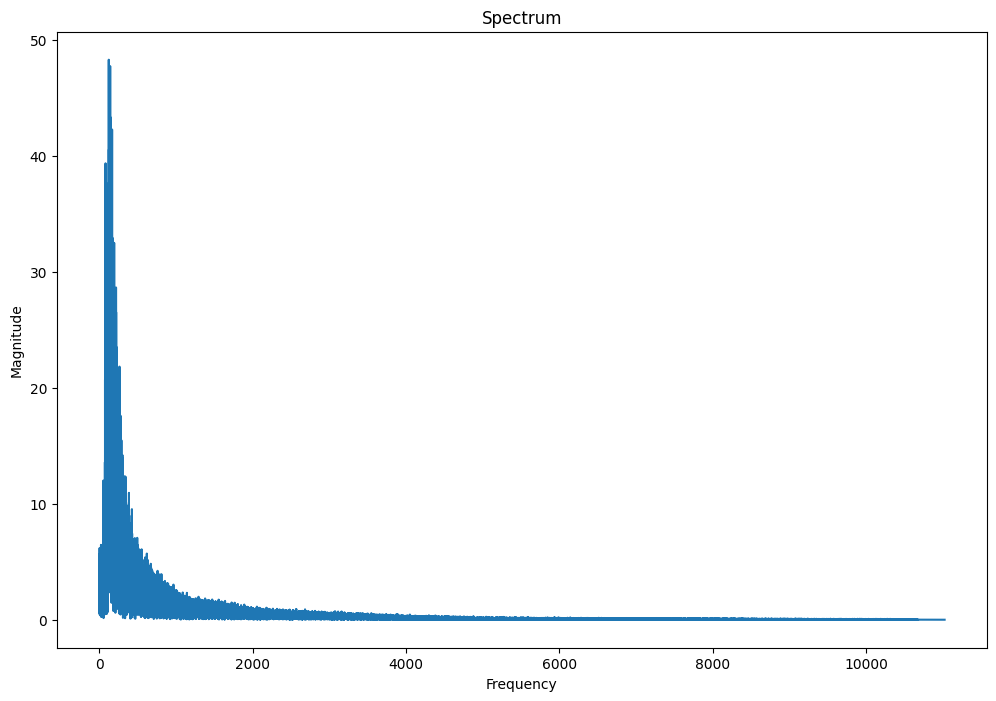

In [ ]:
show_audio_spectrum(normal_sample)


STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


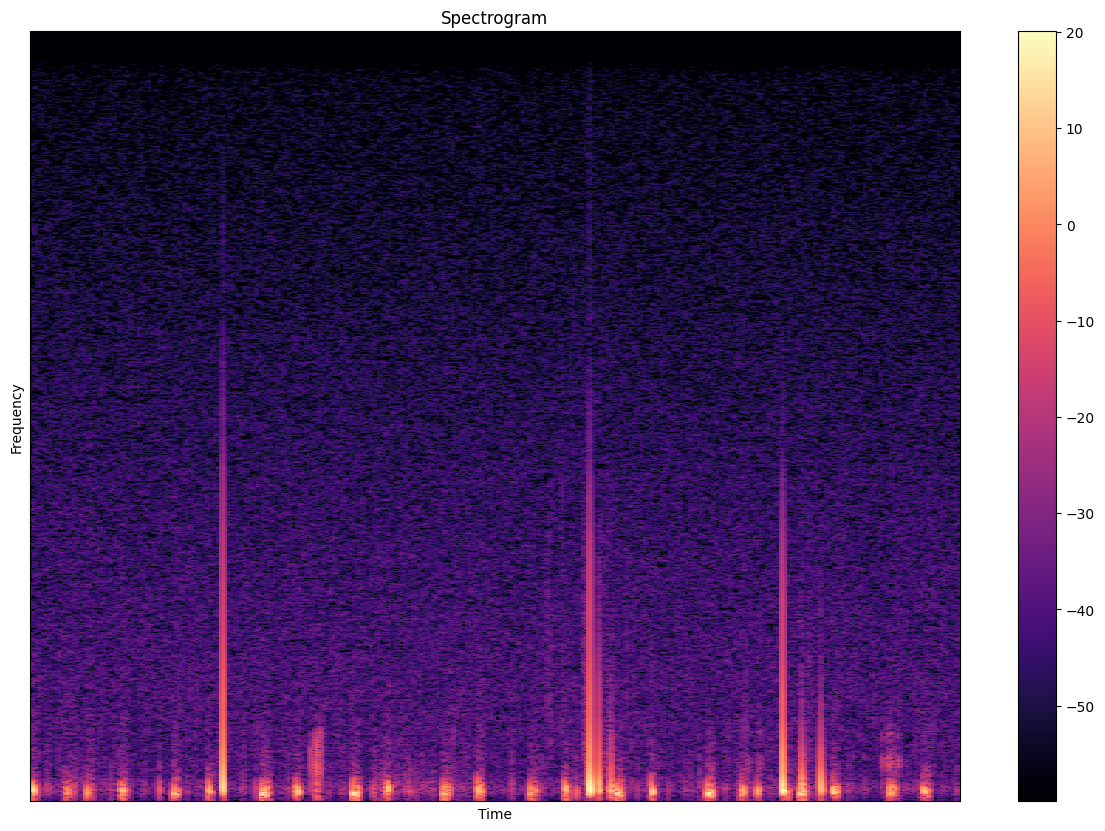

In [ ]:
show_spectrogram(normal_sample)

In [ ]:
def show_mfcc_features(audio_sample):
    sample_rate = 22050
    hop_length = 512
    n_fft = 2048

    mfccs = librosa.feature.mfcc(y=audio_sample, sr=sample_rate, hop_length=hop_length, n_fft=n_fft, n_mfcc=52)

    plt.figure(figsize=(15, 10))
    librosa.display.specshow(mfccs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()

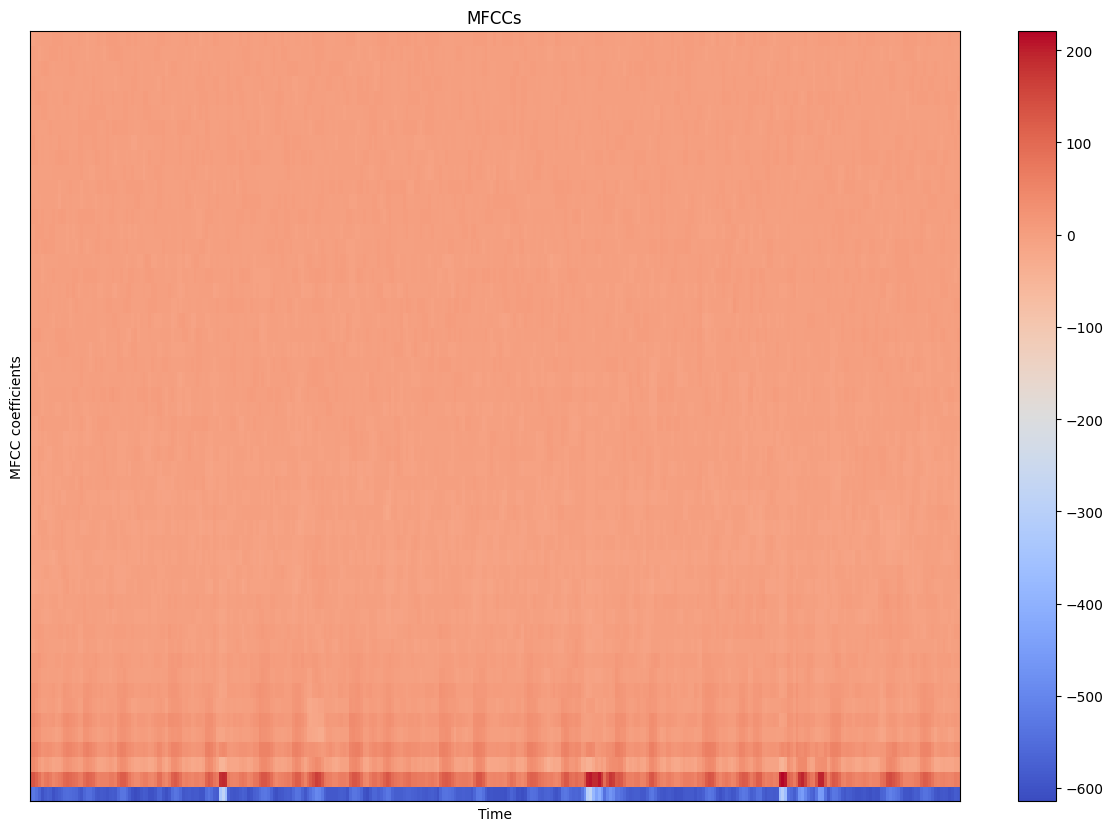

In [ ]:
show_mfcc_features(normal_sample)


In [ ]:
murmur_audio, murmur_sample  = random_sound(murmur_data)
murmur_audio

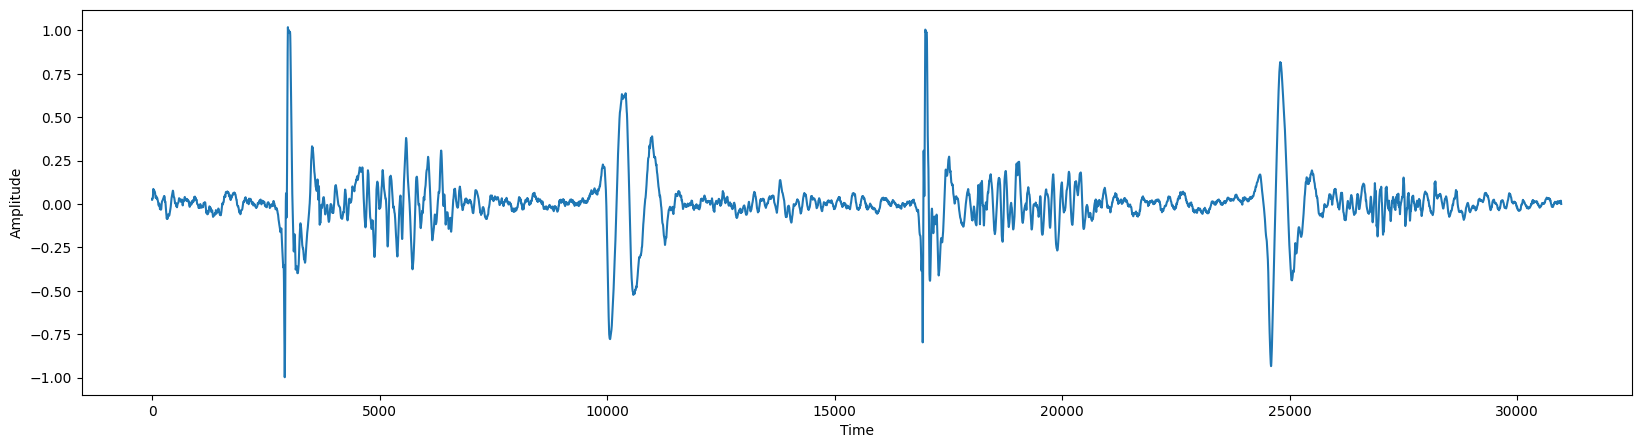

In [ ]:
show_audio_waveform(murmur_sample)

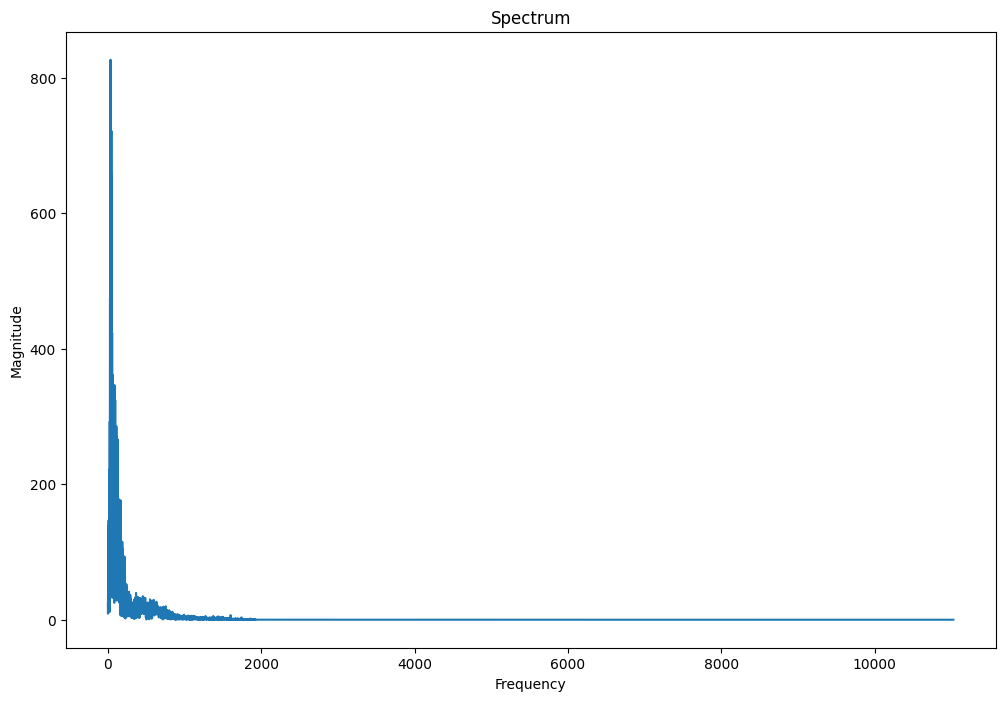

In [ ]:
show_audio_spectrum(murmur_sample)


STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


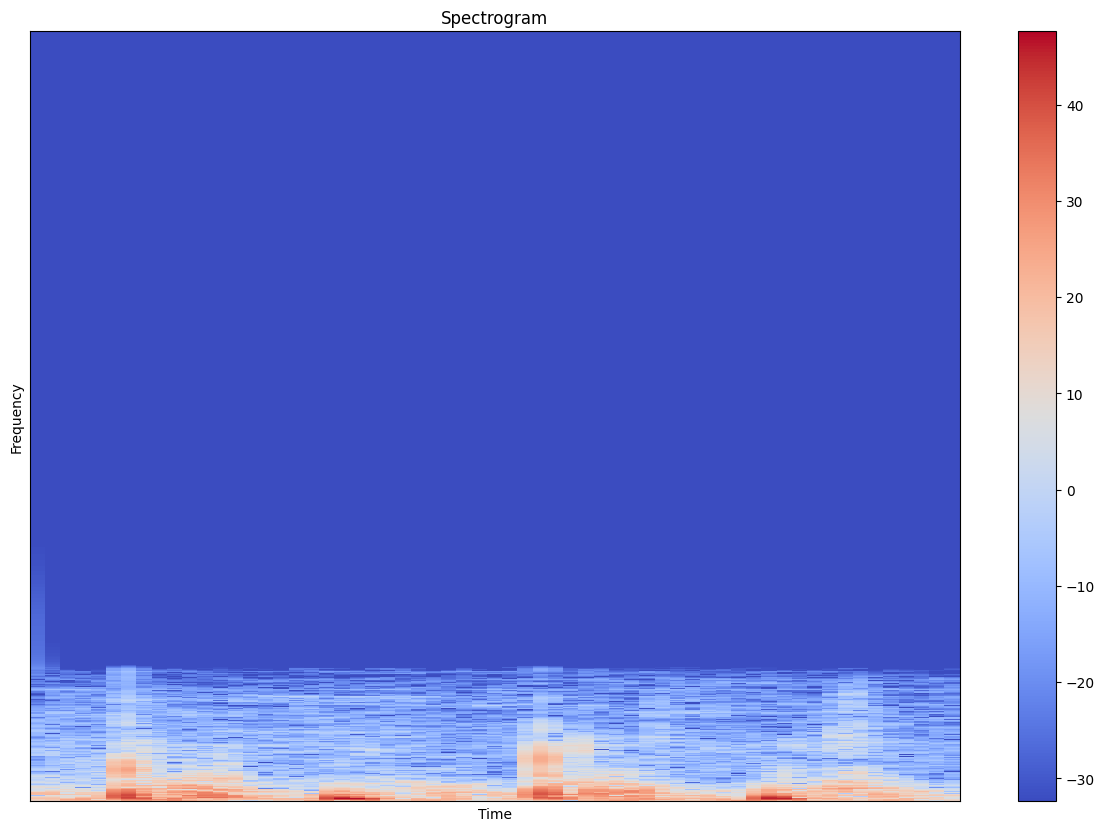

In [ ]:
show_spectrogram(murmur_sample)

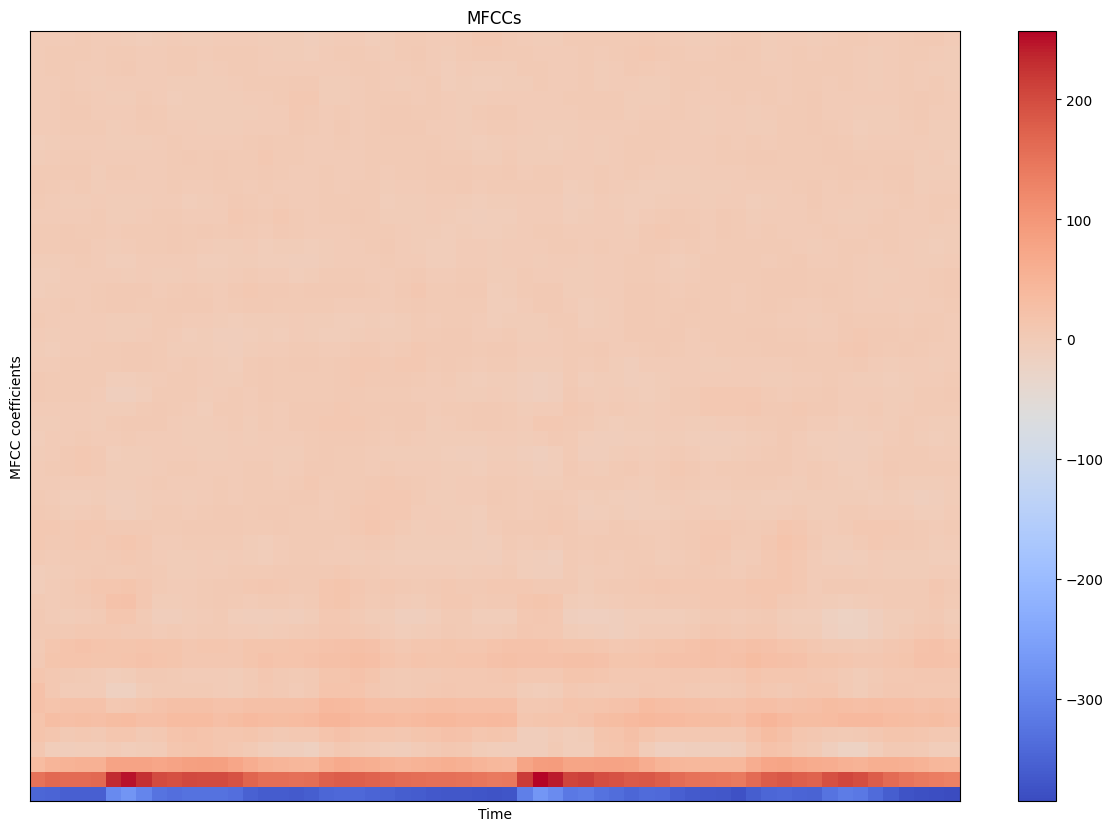

In [ ]:
show_mfcc_features(murmur_sample)

In [ ]:
extrastole_audio, extrastole_sample  = random_sound(extrastole_data)
extrastole_audio

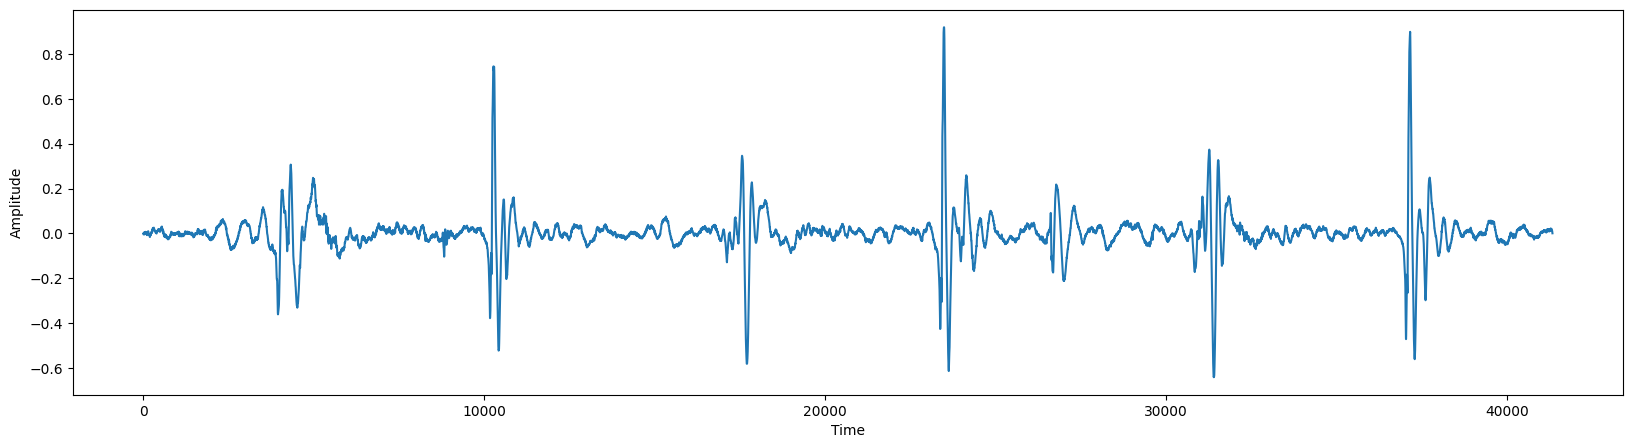

In [ ]:
show_audio_waveform(extrastole_sample)

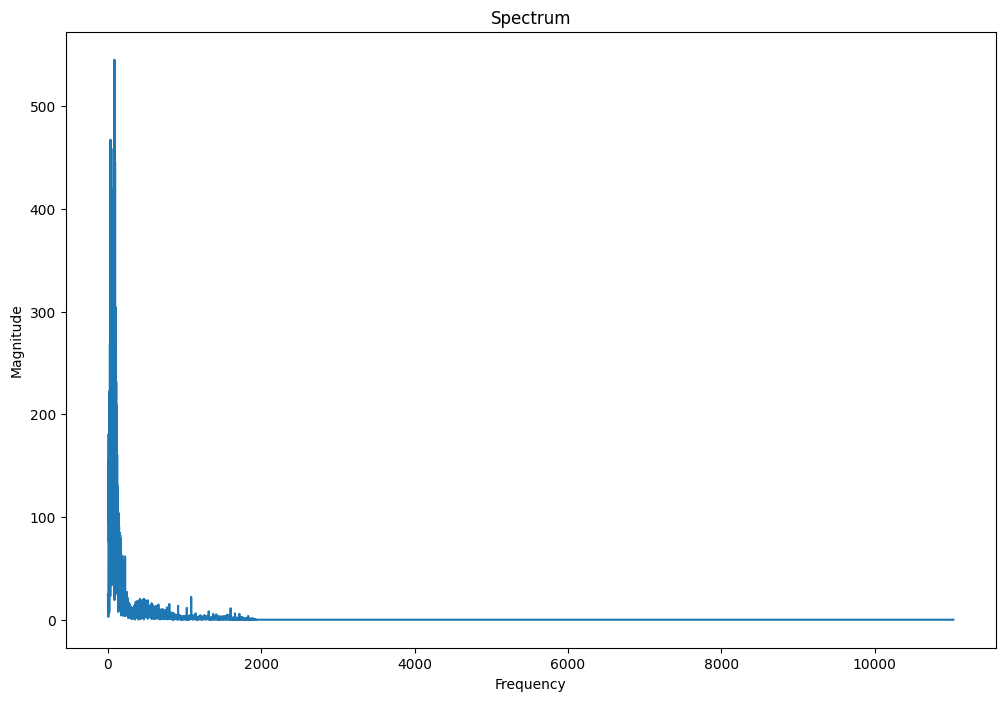

In [ ]:
show_audio_spectrum(extrastole_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


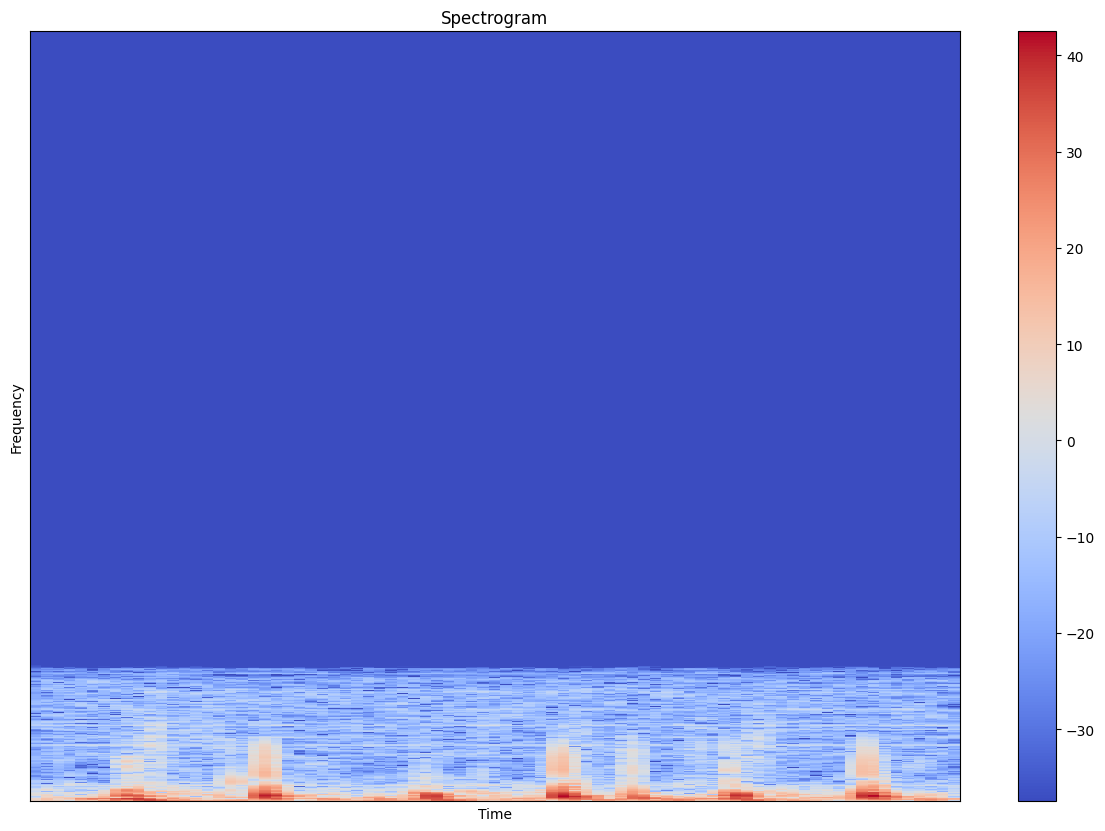

In [ ]:
show_spectrogram(extrastole_sample)

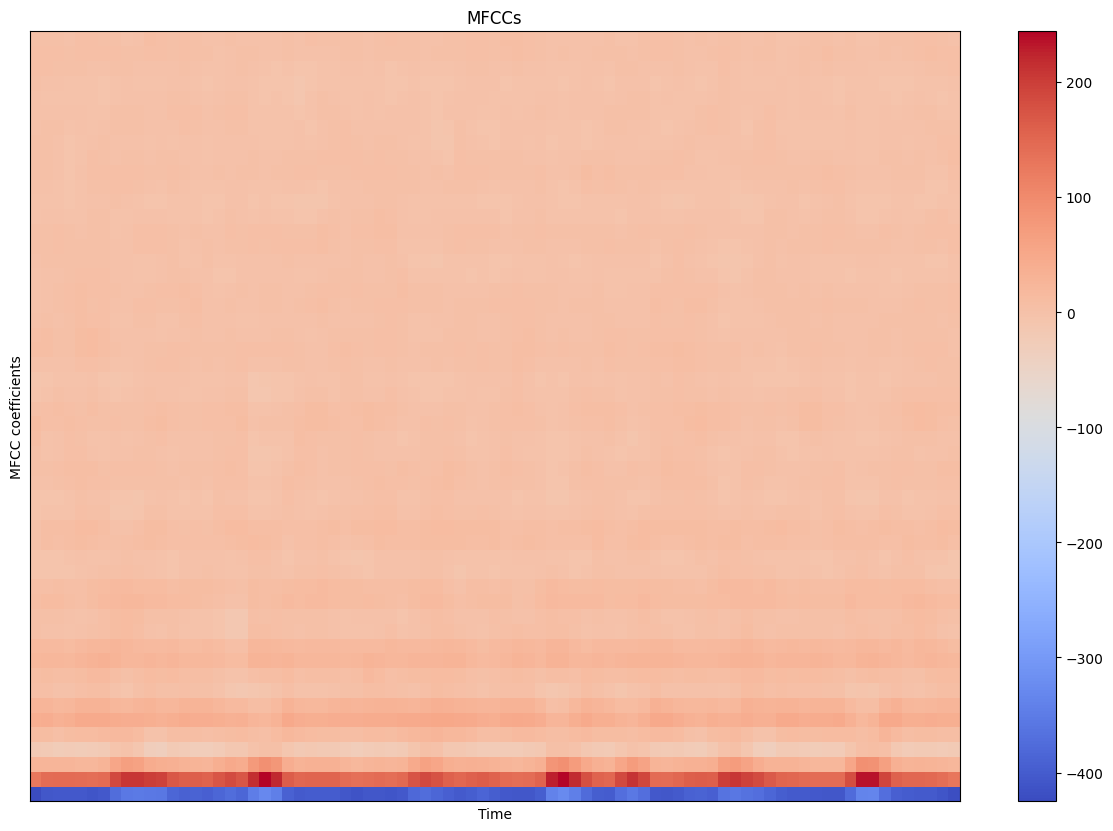

In [ ]:
show_mfcc_features(extrastole_sample)

In [ ]:
artifact_audio, artifact_sample  = random_sound(artifact_data)
artifact_audio

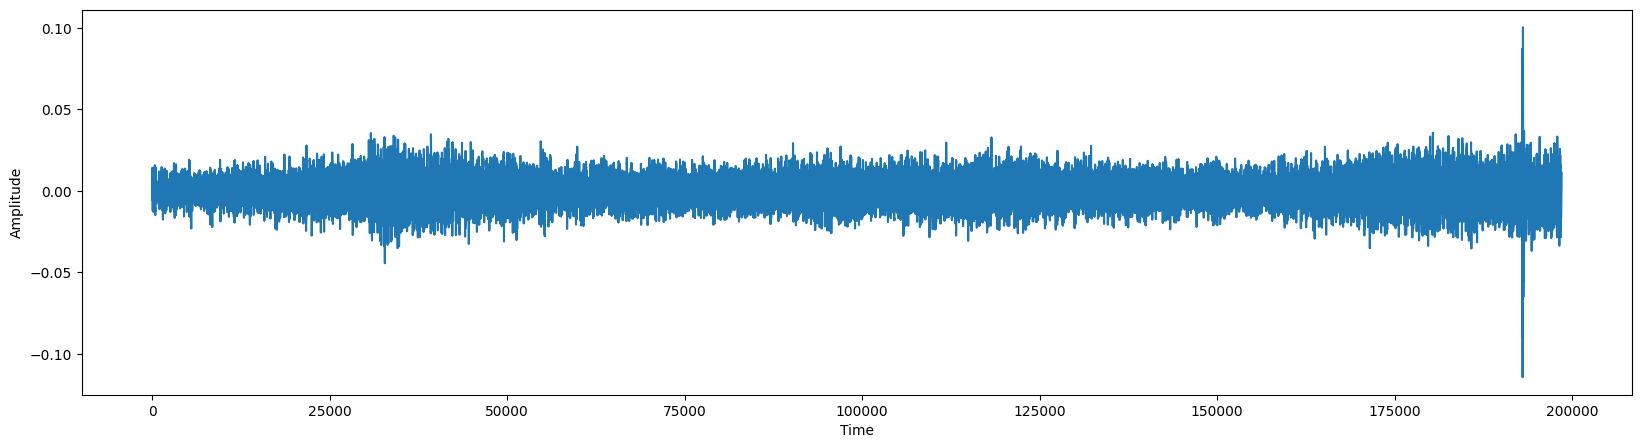

In [ ]:
show_audio_waveform(artifact_sample)

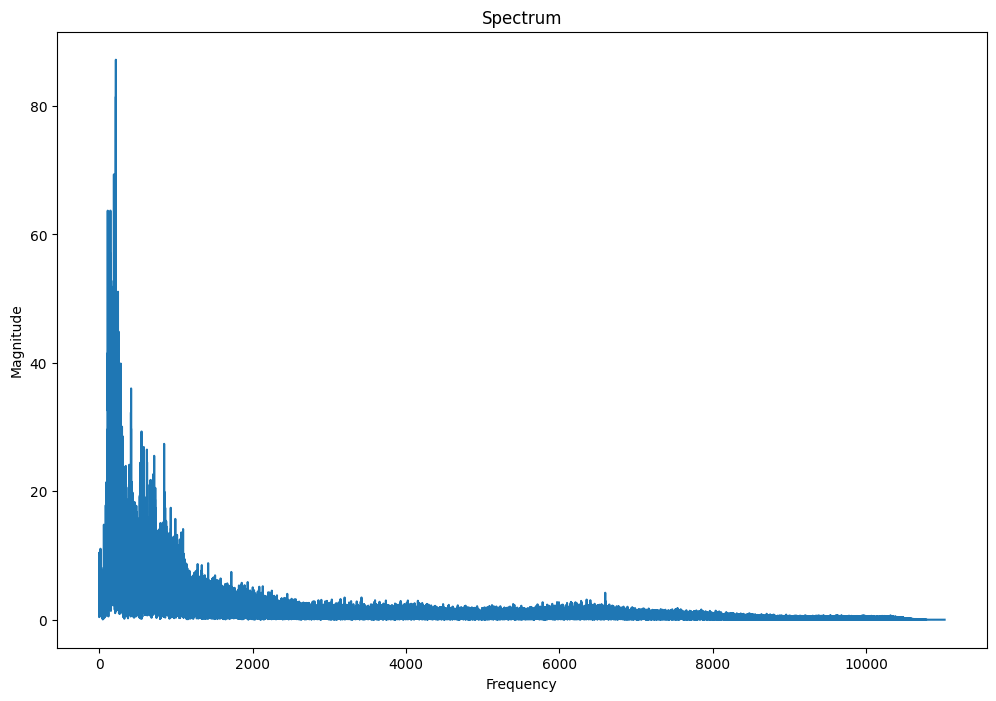

In [ ]:
show_audio_spectrum(artifact_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


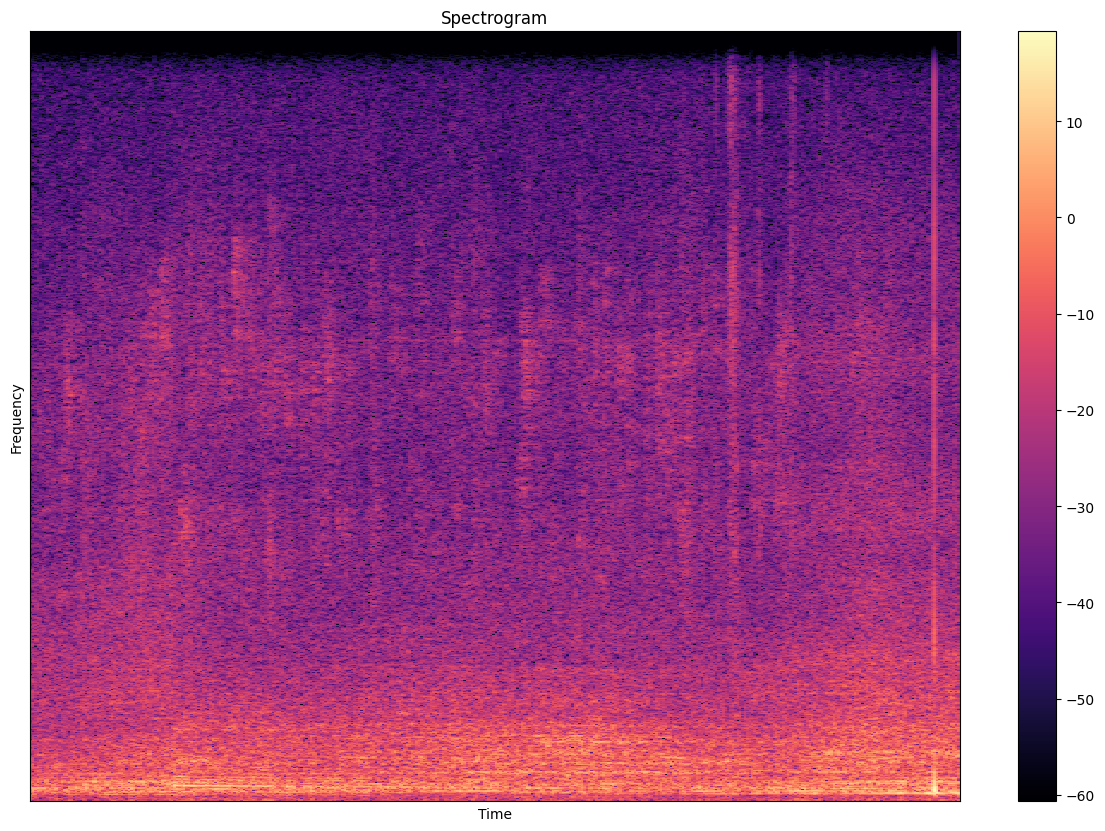

In [ ]:
show_spectrogram(artifact_sample)

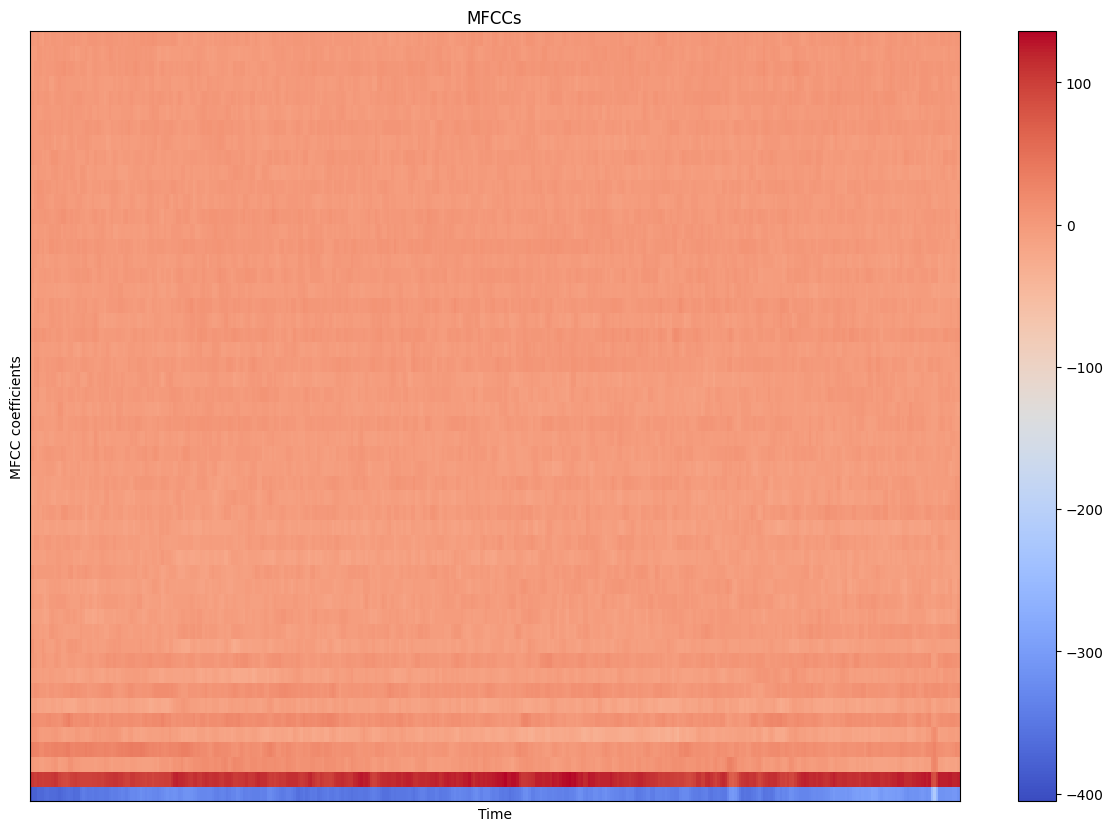

In [ ]:
show_mfcc_features(artifact_sample)

In [ ]:
extrahls_audio, extrahls_sample  = random_sound(extrahls_data)
extrahls_audio

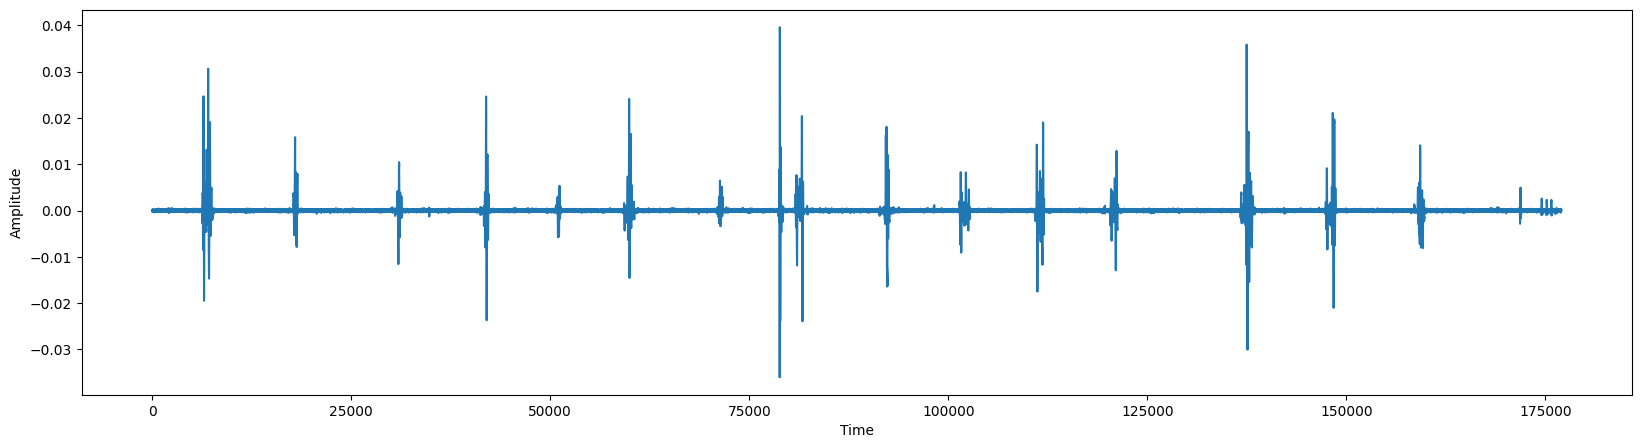

In [ ]:
show_audio_waveform(extrahls_sample)

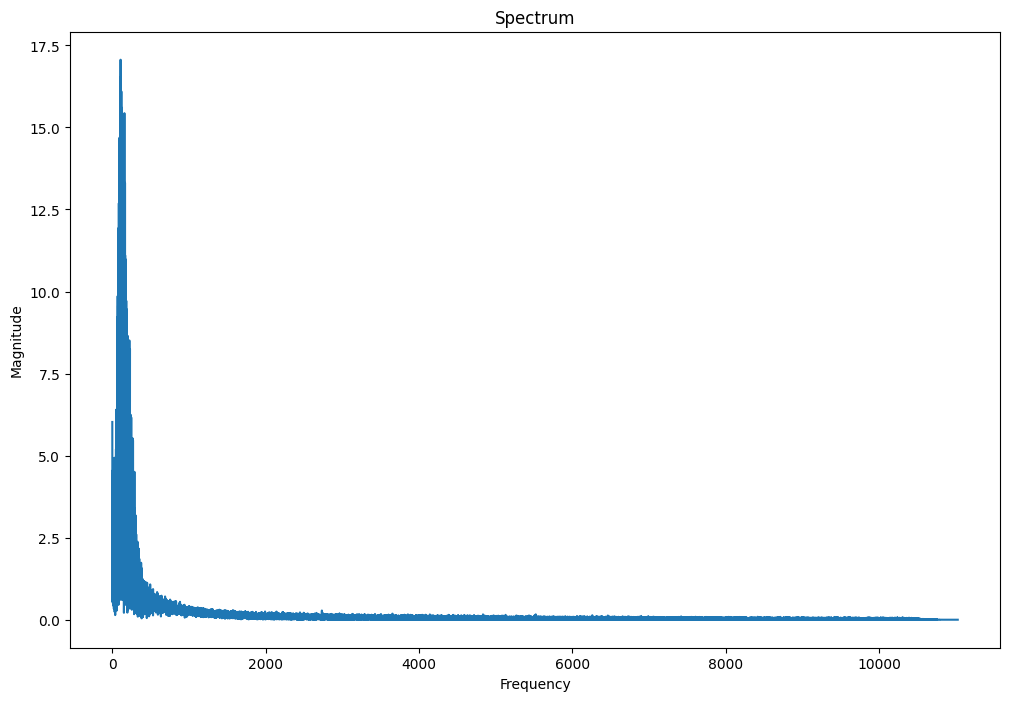

In [ ]:
show_audio_spectrum(extrahls_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


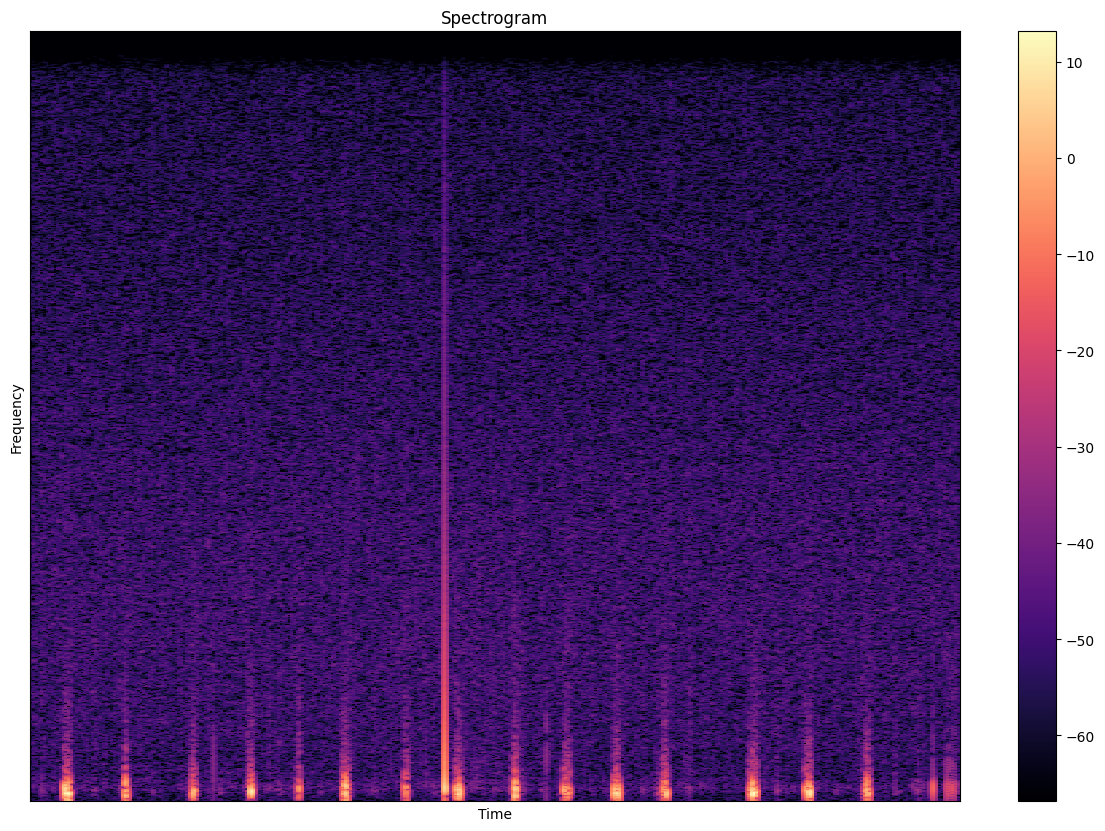

In [ ]:
show_spectrogram(extrahls_sample)

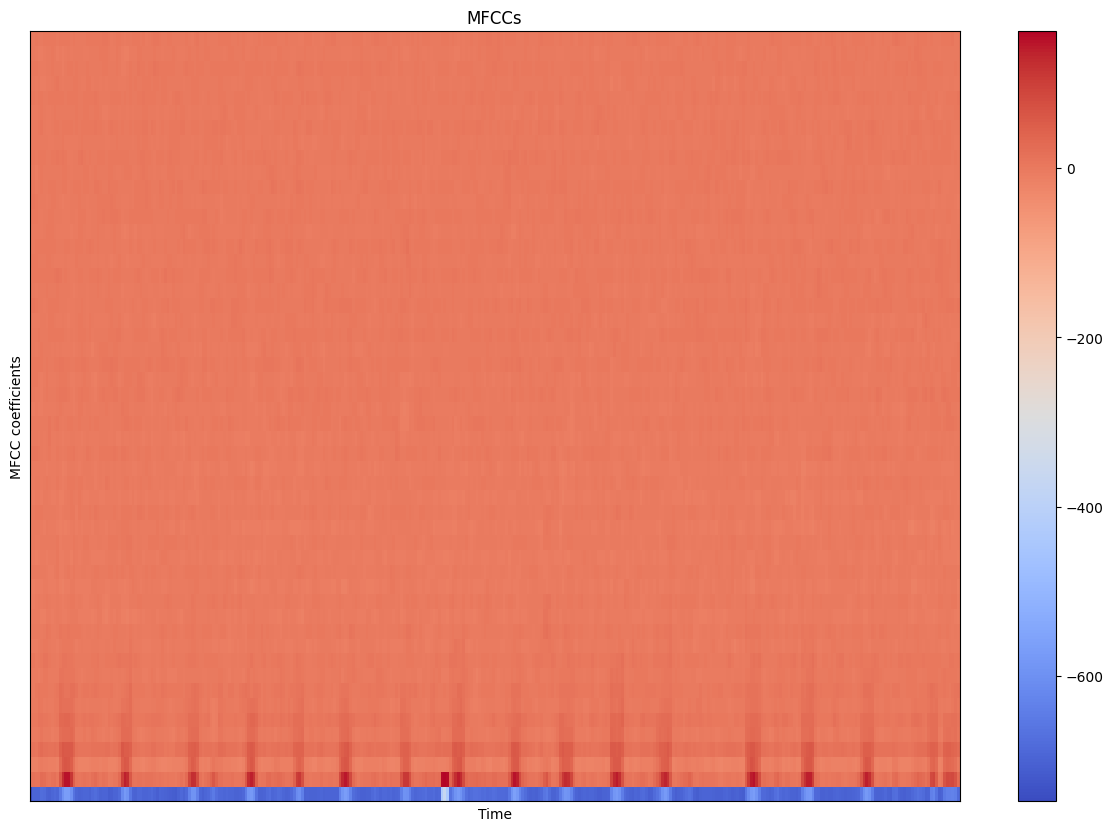

In [ ]:
show_mfcc_features(extrahls_sample)

In [ ]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [ ]:
import os
import librosa
import numpy as np
import traceback

def fix_audio_length(audio_dir, desired_length):
    for file_name in os.listdir(audio_dir):
        file_path = os.path.join(audio_dir, file_name)
        if file_name.endswith('.wav'):
            try:
                print("Fixing audio length:", file_name)
                X, sr = librosa.load(file_path, sr=None)
                
                if len(X) < desired_length:
                    X = np.pad(X, (0, desired_length - len(X)), 'constant')
                elif len(X) > desired_length:
                    X = X[:desired_length]
                
                librosa.output.write_wav(file_path, X, sr)
            except Exception as e:
                print("Error encountered while fixing audio length:", file_name)
                print(str(e))

def load_file_data(folder, file_names, duration, sr=22050):
    data = []
    for file_name in file_names:
        try:
            file_path = os.path.join(folder, file_name)
            X, sample_rate = librosa.load(file_path, sr=sr, duration=duration)
            input_length = sr * duration
            if len(X) < input_length:
                print("Fixing audio length:", file_name)
                X = np.pad(X, (0, input_length - len(X)), 'constant')
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=25).T, axis=0)
        except Exception as e:
            print("Error encountered while parsing file:", file_name)
            traceback.print_exc()
            mfccs = []  
        feature = np.array(mfccs).reshape([-1, 1])
        data.append(feature)
    return data

# Örnek kullanım
audio_directory = "/content/drive/MyDrive/Colab Notebooks/YZ_Uygulamaları/Heartbeat_Sound"
desired_length = 22050  
fix_audio_length(audio_directory, desired_length)

In [ ]:
# simple encoding of categories, convert to only 3 types:
# Normal (Include extrahls and extrastole)
# Murmur
# Artifact

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [ ]:
# 22 KHz
SAMPLE_RATE = 22050
# 10 seconds
MAX_SOUND_CLIP_DURATION=10

artifact_files = fnmatch.filter(os.listdir(artifact_data), 'artifact*.wav')
artifact_sounds = load_file_data (folder=artifact_data, file_names = artifact_files, duration=MAX_SOUND_CLIP_DURATION)
artifact_labels = [0 for items in artifact_sounds]

normal_files = fnmatch.filter(os.listdir(normal_data), 'normal*.wav')
normal_sounds = load_file_data(folder=normal_data,file_names=normal_files, duration=MAX_SOUND_CLIP_DURATION)
normal_labels = [2 for items in normal_sounds]

extrahls_files = fnmatch.filter(os.listdir(extrahls_data), 'extrahls*.wav')
extrahls_sounds = load_file_data(folder=extrahls_data,file_names=extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
extrahls_labels = [2 for items in extrahls_sounds]

murmur_files = fnmatch.filter(os.listdir(murmur_data), 'murmur*.wav')
murmur_sounds = load_file_data(folder=murmur_data,file_names=murmur_files, duration=MAX_SOUND_CLIP_DURATION)
murmur_labels = [1 for items in murmur_sounds]


extrastole_files = fnmatch.filter(os.listdir(extrastole_data), 'extrastole*.wav')
extrastole_sounds = load_file_data(folder=extrastole_data,file_names=extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
extrastole_labels = [2 for items in extrastole_sounds]

print ("Loading Done")

Fixing audio length: artifact__201106161019.wav
Fixing audio length: artifact__201106010559.wav
Fixing audio length: artifact__201106040933.wav
Fixing audio length: artifact__201106131835.wav
Fixing audio length: artifact__201106161016.wav
Fixing audio length: artifact__201106141701.wav
Fixing audio length: artifact__201106021541.wav
Fixing audio length: artifact__201106121445.wav
Fixing audio length: artifact__201012172012.wav
Fixing audio length: artifact__201106010602.wav
Fixing audio length: artifact__201106070949.wav
Fixing audio length: artifact__201106161219.wav
Fixing audio length: artifact__201106121242.wav
Fixing audio length: artifact__201105190800.wav
Fixing audio length: artifact__201106040947.wav
Fixing audio length: artifact__201106031558.wav
Fixing audio length: artifact__201106101314.wav
Fixing audio length: artifact__201106131834.wav
Fixing audio length: artifact__201106050353.wav
Fixing audio length: artifact__201105061143.wav
Fixing audio length: artifact__201105040

In [ ]:
# unlabel_datala files
Bunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Bunlabelledtest*.wav')
Bunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Bunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Bunlabelledtest_labels = [-1 for items in Bunlabelledtest_sounds]

Aunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Aunlabelledtest*.wav')
Aunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Aunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Aunlabelledtest_labels = [-1 for items in Aunlabelledtest_sounds]


print ("Loading of unlabel data done")

Fixing audio length: Bunlabelledtest__113_1306244002866_C.wav
Fixing audio length: Bunlabelledtest__118_1306262335509_C2.wav
Fixing audio length: Bunlabelledtest__118_1306262335509_A.wav
Fixing audio length: Bunlabelledtest__106_1306776721273_D.wav
Fixing audio length: Bunlabelledtest__109_1305653972028_D.wav
Fixing audio length: Bunlabelledtest__103_1305031931979_A.wav
Fixing audio length: Bunlabelledtest__106_1306776721273_B.wav
Fixing audio length: Bunlabelledtest__107_1305654946865_B.wav
Fixing audio length: Bunlabelledtest__112_1306243000964_C.wav
Fixing audio length: Bunlabelledtest__103_1305031931979_C.wav
Fixing audio length: Bunlabelledtest__117_1306262456650_B1.wav
Fixing audio length: Bunlabelledtest__101_1305030823364_F.wav
Fixing audio length: Bunlabelledtest__109_1305653972028_B.wav
Fixing audio length: Bunlabelledtest__118_1306262335509_A1.wav
Fixing audio length: Bunlabelledtest__150_1306776340746_D.wav
Fixing audio length: Bunlabelledtest__146_1306778707532_D31.wav
Fix

In [ ]:
#combine set-a and set-b 
x_data = np.concatenate((artifact_sounds, normal_sounds,extrahls_sounds,murmur_sounds,extrastole_sounds))

y_data = np.concatenate((artifact_labels, normal_labels,extrahls_labels,murmur_labels,extrastole_labels))

test_x = np.concatenate((Aunlabelledtest_sounds,Bunlabelledtest_sounds))
test_y = np.concatenate((Aunlabelledtest_labels,Bunlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  585 247


In [ ]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

In [ ]:
# class weight 
TRAIN_IMG_COUNT = 578
COUNT_0 = 40  #artifact
COUNT_1 = 129 #murmur
COUNT_2 = 409 #normal
weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
class_weight

{0: 4.816666666666666, 1: 1.4935400516795865, 2: 0.4710676446617767}

In [ ]:
x_train_lstm = x_train
x_val_lstm = x_test
x_test_lstm = x_val

y_train_lstm = y_train
y_val_lstm = y_test
y_test_lstm = y_val

In [ ]:
lstm_model = Sequential()

lstm_model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(25, 1)))  # Update the input shape to (25, 1)
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(LSTM(256, return_sequences=True))
lstm_model.add(LSTM(128))


lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(3, activation='softmax'))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 25, 2048)          12288     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 13, 2048)         0         
 1D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 13, 2048)         8192      
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 13, 1024)          10486784  
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 7, 1024)          0         
 1D)                                                             
                                                      

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cb = [EarlyStopping(patience=20,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/kaggle/working/Heart_LSTM_CNN_1.h5",save_best_only=True)]

In [ ]:
history = lstm_model.fit(x_train_lstm, y_train_lstm, 
                         validation_data=(x_val_lstm, y_val_lstm),
                         batch_size=8, epochs=250, 
                         class_weight=class_weight, callbacks=cb)

Epoch 1/250
53/53 [==============================] - 62s 1s/step - loss: 1.0100 - accuracy: 0.4133 - val_loss: 0.9717 - val_accuracy: 0.2308
Epoch 2/250
53/53 [==============================] - 65s 1s/step - loss: 0.8370 - accuracy: 0.3943 - val_loss: 0.9210 - val_accuracy: 0.2479
Epoch 3/250
53/53 [==============================] - 54s 1s/step - loss: 0.8125 - accuracy: 0.4181 - val_loss: 0.8656 - val_accuracy: 0.5128
Epoch 4/250
53/53 [==============================] - 52s 984ms/step - loss: 0.6692 - accuracy: 0.4751 - val_loss: 0.8911 - val_accuracy: 0.4274
Epoch 5/250
53/53 [==============================] - 54s 1s/step - loss: 0.6682 - accuracy: 0.4846 - val_loss: 0.8283 - val_accuracy: 0.3675
Epoch 6/250
53/53 [==============================] - 73s 1s/step - loss: 0.6774 - accuracy: 0.4941 - val_loss: 0.7764 - val_accuracy: 0.3590
Epoch 7/250
53/53 [==============================] - 59s 1s/step - loss: 0.7039 - accuracy: 0.4798 - val_loss: 0.8714 - val_accuracy: 0.4017
Epoch 8/25

In [ ]:
lstm_model.evaluate(x_val_lstm, y_val_lstm)


4/4 [==============================] - 1s 168ms/step - loss: 0.5582 - accuracy: 0.8376


[0.5581809282302856, 0.8376068472862244]

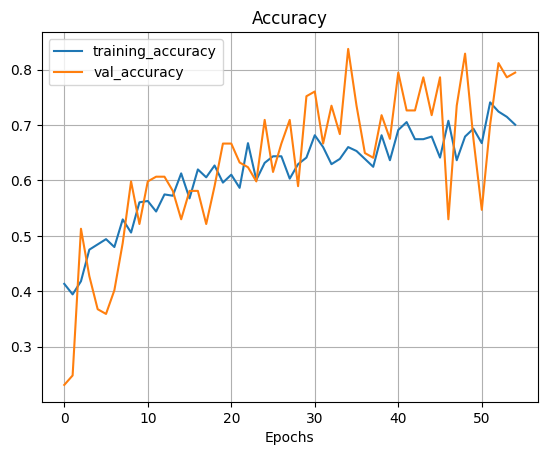

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history)

2/2 [==============================] - 2s 177ms/step


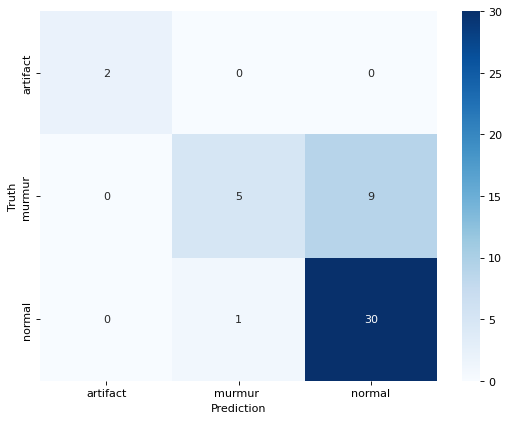

In [ ]:
classes = ["artifact" ,"murmur ", "normal"]

preds = lstm_model.predict(x_test_lstm)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_lstm]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00         2
     murmur        0.83      0.36      0.50        14
      normal       0.77      0.97      0.86        31

    accuracy                           0.79        47
   macro avg       0.87      0.77      0.79        47
weighted avg       0.80      0.79      0.76        47



In [ ]:
def heart_prediction (file_path, duration=10, sr=22050):
    classes=["artifact","murmur","normal"]
    input_length=sr*duration
    
    X, sr = librosa.load(file_path, sr=sr, duration=duration) 
    dur = librosa.get_duration(y=X, sr=sr)
    
    # pad audio file same duration
    if (round(dur) < duration):
        X = librosa.util.fix_length(X, input_length)
        
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=52, n_fft=512,hop_length=2048).T,axis=0)
    feature = np.array(mfccs).reshape([-1,1])
    
    preds=lstm_model.predict(mfccs.reshape(1,52,1))
    preds=classes [np.argmax(preds)]
    confidence = np.amax(preds)
    return preds, confidence 